In [1]:
import os
import sys 
import json
import glob
import random
import collections
import time
import re

import numpy as np
import pandas as pd
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut
import cv2
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
from torch.utils import data as torch_data
from sklearn import model_selection as sk_model_selection
from torch.nn import functional as torch_functional
import torch.nn.functional as F

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

In [2]:
data_directory = '/projectnb2/ece601/zhaojw'
pytorch3dpath = "/projectnb2/ece601/zhaojw/EfficientNet-PyTorch-3D-master/EfficientNet-PyTorch-3D"
    
mri_types = ['T1w','FLAIR','T1wCE','T2w']
# mri_types = ['FLAIR']
SIZE = 256
NUM_IMAGES = 64

sys.path.append(pytorch3dpath)
from efficientnet_pytorch_3d import EfficientNet3D

# Functions to load images

In [3]:
def load_dicom_image(path, img_size=SIZE, voi_lut=True, rotate=0):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
        
    if rotate > 0:
        rot_choices = [0, cv2.ROTATE_90_CLOCKWISE, cv2.ROTATE_90_COUNTERCLOCKWISE, cv2.ROTATE_180]
        data = cv2.rotate(data, rot_choices[rotate])
        
    data = cv2.resize(data, (img_size, img_size))
    return data

def load_dicom_images_3d(scan_id, num_imgs=NUM_IMAGES, img_size=SIZE, mri_type="FLAIR", split="train", rotate=0):

    files = sorted(glob.glob(f"{data_directory}/{split}/{scan_id}/{mri_type}/*.dcm"), 
               key=lambda var:[int(x) if x.isdigit() else x for x in re.findall(r'[^0-9]|[0-9]+', var)])

    middle = len(files)//2
    num_imgs2 = num_imgs//2
    p1 = max(0, middle - num_imgs2)
    p2 = min(len(files), middle + num_imgs2)
    img3d = np.stack([load_dicom_image(f, rotate=rotate) for f in files[p1:p2]]).T 
    if img3d.shape[-1] < num_imgs:
        n_zero = np.zeros((img_size, img_size, num_imgs - img3d.shape[-1]))
        img3d = np.concatenate((img3d,  n_zero), axis = -1)
        
    if np.min(img3d) < np.max(img3d):
        img3d = img3d - np.min(img3d)
        img3d = img3d / np.max(img3d)
            
    return np.expand_dims(img3d,0)

a = load_dicom_images_3d("00002")
print(a.shape)
print(np.min(a), np.max(a), np.mean(a), np.median(a))

(1, 256, 256, 64)
0.0 1.0 0.0537724106363252 0.0


In [4]:
def set_seed(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

set_seed(12)

# train / test splits

In [5]:
train_df = pd.read_csv(f"{data_directory}/train_labels.csv")
display(train_df)

df_train, df_valid = sk_model_selection.train_test_split(
    train_df, 
    test_size=0.2, 
    random_state=12, 
    stratify=train_df["MGMT_value"],
)

,BraTS21ID,MGMT_value
0,2,1
1,5,1
2,6,1
3,8,1
4,9,0
...,...,...
530,1005,1
531,1007,1
532,1008,1
533,1009,0


In [6]:
df_train.tail()

,BraTS21ID,MGMT_value
99,157,0
181,288,0
160,251,0
321,517,1
226,356,0


# Model and training classes

In [7]:
class Dataset(torch_data.Dataset):
    def __init__(self, paths, targets=None, mri_type=None, label_smoothing=0.01, split="train", augment=False):
        self.paths = paths
        self.targets = targets
        self.mri_type = mri_type
        self.label_smoothing = label_smoothing
        self.split = split
        self.augment = augment
          
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
        scan_id = self.paths[index]
        if self.targets is None:
            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split=self.split)
        else:
            if self.augment:
                rotation = np.random.randint(0,4)
            else:
                rotation = 0

            data = load_dicom_images_3d(str(scan_id).zfill(5), mri_type=self.mri_type[index], split="train", rotate=rotation)

        if self.targets is None:
            return {"X": torch.tensor(data).float(), "id": scan_id}
        else:
            y = torch.tensor(abs(self.targets[index]-self.label_smoothing), dtype=torch.float)
            return {"X": torch.tensor(data).float(), "y": y}

In [8]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = EfficientNet3D.from_name("efficientnet-b0", override_params={'num_classes': 2}, in_channels=1)
        n_features = self.net._fc.in_features
        self.net._fc = nn.Linear(in_features=n_features, out_features=1, bias=True)
    
    def forward(self, x):
        out = self.net(x)
        return out

In [9]:
class Trainer:
    def __init__(
        self, 
        model, 
        device, 
        optimizer, 
        criterion
    ):
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.criterion = criterion

        self.best_valid_score = np.inf
        self.n_patience = 0
        self.lastmodel = None
        
    def fit(self, epochs, train_loader, valid_loader, save_path, patience):        
        for n_epoch in range(1, epochs + 1):
            self.info_message("EPOCH: {}", n_epoch)
            
            train_loss, train_time = self.train_epoch(train_loader)
            valid_loss, valid_auc, valid_time = self.valid_epoch(valid_loader)
            
            self.info_message(
                "[Epoch Train: {}] loss: {:.4f}, time: {:.2f} s            ",
                n_epoch, train_loss, train_time
            )
            
            self.info_message(
                "[Epoch Valid: {}] loss: {:.4f}, auc: {:.4f}, time: {:.2f} s",
                n_epoch, valid_loss, valid_auc, valid_time
            )

            # if True:
            #if self.best_valid_score < valid_auc: 
            if self.best_valid_score > valid_loss: 
                self.save_model(n_epoch, save_path, valid_loss, valid_auc)
                self.info_message(
                     "auc improved from {:.4f} to {:.4f}. Saved model to '{}'", 
                    self.best_valid_score, valid_loss, self.lastmodel
                )
                self.best_valid_score = valid_loss
                self.n_patience = 0
            else:
                self.n_patience += 1
            
            if self.n_patience >= patience:
                self.info_message("\nValid auc didn't improve last {} epochs.", patience)
                break
            
    def train_epoch(self, train_loader):
        self.model.train()
        t = time.time()
        sum_loss = 0

        for step, batch in enumerate(train_loader, 1):
            X = batch["X"].to(self.device)
            targets = batch["y"].to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(X).squeeze(1)
            
            loss = self.criterion(outputs, targets)
            loss.backward()

            sum_loss += loss.detach().item()

            self.optimizer.step()
            
            message = 'Train Step {}/{}, train_loss: {:.4f}'
            self.info_message(message, step, len(train_loader), sum_loss/step, end="\r")
        
        return sum_loss/len(train_loader), int(time.time() - t)
    
    def valid_epoch(self, valid_loader):
        self.model.eval()
        t = time.time()
        sum_loss = 0
        y_all = []
        outputs_all = []

        for step, batch in enumerate(valid_loader, 1):
            with torch.no_grad():
                X = batch["X"].to(self.device)
                targets = batch["y"].to(self.device)

                outputs = self.model(X).squeeze(1)
                loss = self.criterion(outputs, targets)

                sum_loss += loss.detach().item()
                y_all.extend(batch["y"].tolist())
                outputs_all.extend(torch.sigmoid(outputs).tolist())

            message = 'Valid Step {}/{}, valid_loss: {:.4f}'
            self.info_message(message, step, len(valid_loader), sum_loss/step, end="\r")
            
        y_all = [1 if x > 0.5 else 0 for x in y_all]
        auc = roc_auc_score(y_all, outputs_all)
        
        return sum_loss/len(valid_loader), auc, int(time.time() - t)
    
    def save_model(self, n_epoch, save_path, loss, auc):
        self.lastmodel = f"{save_path}-e{n_epoch}-loss{loss:.3f}-auc{auc:.3f}.pth"
        torch.save(
            {
                "model_state_dict": self.model.state_dict(),
                "optimizer_state_dict": self.optimizer.state_dict(),
                "best_valid_score": self.best_valid_score,
                "n_epoch": n_epoch,
            },
            self.lastmodel,
        )
    
    @staticmethod
    def info_message(message, *args, end="\n"):
        print(message.format(*args), end=end)

# train models

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def train_mri_type(df_train, df_valid, mri_type):
    if mri_type=="all":
        train_list = []
        valid_list = []
        for mri_type in mri_types:
            df_train.loc[:,"MRI_Type"] = mri_type
            train_list.append(df_train.copy())
            df_valid.loc[:,"MRI_Type"] = mri_type
            valid_list.append(df_valid.copy())

        df_train = pd.concat(train_list)
        df_valid = pd.concat(valid_list)
    else:
        df_train.loc[:,"MRI_Type"] = mri_type
        df_valid.loc[:,"MRI_Type"] = mri_type

    print(df_train.shape, df_valid.shape)
    display(df_train.head())
    
    train_data_retriever = Dataset(
        df_train["BraTS21ID"].values, 
        df_train["MGMT_value"].values, 
        df_train["MRI_Type"].values,
        augment=True
    )

    valid_data_retriever = Dataset(
        df_valid["BraTS21ID"].values, 
        df_valid["MGMT_value"].values,
        df_valid["MRI_Type"].values
    )

    train_loader = torch_data.DataLoader(
        train_data_retriever,
        batch_size=4,
        shuffle=True,
        num_workers=8,pin_memory = True
    )

    valid_loader = torch_data.DataLoader(
        valid_data_retriever, 
        batch_size=4,
        shuffle=False,
        num_workers=8,pin_memory = True
    )

    model = Model()
    model.to(device)

    #checkpoint = torch.load("best-model-all-auc0.555.pth")
    #model.load_state_dict(checkpoint["model_state_dict"])

    #print(model)

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

    criterion = torch_functional.binary_cross_entropy_with_logits

    trainer = Trainer(
        model, 
        device, 
        optimizer, 
        criterion
    )

    history = trainer.fit(
        10, 
        train_loader, 
        valid_loader, 
        f"{mri_type}", 
        10,
    )
    
    return trainer.lastmodel

# modelfiles = None

# if not modelfiles:
#     modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
#     print(modelfiles)

In [31]:
modelfiles = None

if not modelfiles:
    modelfiles = [train_mri_type(df_train, df_valid, m) for m in mri_types]
    print(modelfiles)

# Predict function

In [11]:
def predict(modelfile, df, mri_type, split):
    print("Predict:", modelfile, mri_type, df.shape)
    df.loc[:,"MRI_Type"] = mri_type
    data_retriever = Dataset(
        df.index.values, 
        mri_type=df["MRI_Type"].values,
        split=split
    )

    data_loader = torch_data.DataLoader(
        data_retriever,
        batch_size=4,
        shuffle=False,
        num_workers=8,
    )
   
    model = Model()
    model.to(device)
    
    checkpoint = torch.load(modelfile)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()
    
    y_pred = []
    ids = []

    for e, batch in enumerate(data_loader,1):
        print(f"{e}/{len(data_loader)}", end="\r")
        with torch.no_grad():
            tmp_pred = torch.sigmoid(model(batch["X"].to(device))).cpu().numpy().squeeze()
            if tmp_pred.size == 1:
                y_pred.append(tmp_pred)
            else:
                y_pred.extend(tmp_pred.tolist())
            ids.extend(batch["id"].numpy().tolist())
            
    preddf = pd.DataFrame({"BraTS21ID": ids, "MGMT_value": y_pred}) 
    preddf = preddf.set_index("BraTS21ID")
    return preddf

# Ensemble for validation

In [15]:
df_valid

,BraTS21ID,MGMT_value
259,407,0
439,693,1
364,578,0
249,392,0
428,677,1
...,...,...
177,283,0
90,146,1
367,582,1
310,502,1


In [28]:
mri_types = ['T1w','FLAIR','T1wCE','T2w']
modelfiles = ["T1w-e1-loss0.706-auc0.500.pth","FLAIR-e5-loss0.685-auc0.576.pth","T1wCE-e4-loss0.690-auc0.587.pth",
             "T2w-e10-loss0.688-auc0.586.pth"]
df_valid = df_valid.set_index("BraTS21ID")

Predict: T1w-e1-loss0.706-auc0.500.pth T1w (107, 3)
Predict: FLAIR-e5-loss0.685-auc0.576.pth FLAIR (107, 3)
Predict: T1wCE-e4-loss0.690-auc0.587.pth T1wCE (107, 3)
Predict: T2w-e10-loss0.688-auc0.586.pth T2w (107, 3)
Validation ensemble AUC: 0.6228


,MGMT_value,MGMT_pred,MRI_Type
BraTS21ID,,,
407,0,0.509497,T2w
693,1,0.520739,T2w
578,0,0.473868,T2w
392,0,0.512688,T2w
677,1,0.512206,T2w
...,...,...,...
283,0,0.502616,T2w
146,1,0.507990,T2w
582,1,0.485177,T2w


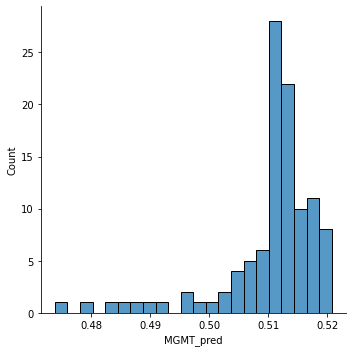

In [29]:
df_valid["MGMT_pred"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_valid, mtype, "train")
    df_valid["MGMT_pred"] += pred["MGMT_value"]
df_valid["MGMT_pred"] /= len(modelfiles)
auc = roc_auc_score(df_valid["MGMT_value"], df_valid["MGMT_pred"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_valid["MGMT_pred"])
df_valid

# Test

In [12]:
# !pip install scikit-plot

import scikitplot as skplt
import matplotlib.pyplot as plt
import sklearn

In [13]:
df_test = pd.read_csv(f"{data_directory}/test_labels.csv")
df_test = df_test.set_index("BraTS21ID")
# display(df_test)

Predict: FLAIR-e1-loss0.693-auc0.500.pth FLAIR (50, 2)
Validation ensemble AUC: 0.5000
Predict: FLAIR-e2-loss0.691-auc0.441.pth FLAIR (50, 3)
Validation ensemble AUC: 0.4179
Predict: FLAIR-e8-loss0.682-auc0.561.pth FLAIR (50, 3)
Validation ensemble AUC: 0.4831
Predict: FLAIR-e5-loss0.685-auc0.576.pth FLAIR (50, 3)
Validation ensemble AUC: 0.5958


,MGMT_value,MGMT_pred_flair,MRI_Type
BraTS21ID,,,
499,1,0.515328,FLAIR
775,1,0.544773,FLAIR
401,0,0.544335,FLAIR
593,1,0.542593,FLAIR
421,0,0.531726,FLAIR


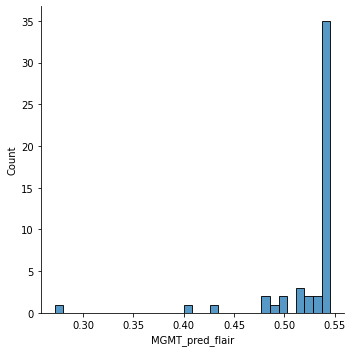

In [14]:
# Flair
# mri_types = ['T1w','FLAIR','T1wCE','T2w']

mri_types = ['FLAIR','FLAIR','FLAIR','FLAIR']
modelfiles = ["FLAIR-e1-loss0.693-auc0.500.pth","FLAIR-e2-loss0.691-auc0.441.pth","FLAIR-e8-loss0.682-auc0.561.pth",
             "FLAIR-e5-loss0.685-auc0.576.pth"]

df_test["MGMT_pred_flair"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_test, mtype, "test")
    df_test["MGMT_pred_flair"] = pred["MGMT_value"]
    auc = roc_auc_score(df_test["MGMT_value"], df_test["MGMT_pred_flair"])
    print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_test["MGMT_pred_flair"])
df_test.head()


Predict: T1w-e1-loss0.706-auc0.500.pth T1w (50, 4)
Validation ensemble AUC: 0.5000
Predict: T1w-e4-loss0.693-auc0.498.pth T1w (50, 4)
Validation ensemble AUC: 0.4026
Predict: T1w-e2-loss0.694-auc0.500.pth T1w (50, 4)
Validation ensemble AUC: 0.5000


,MGMT_value,MGMT_pred_flair,MRI_Type,MGMT_pred_T1w
BraTS21ID,,,,
499,1,0.515328,T1w,0.580202
775,1,0.544773,T1w,0.580202
401,0,0.544335,T1w,0.580202
593,1,0.542593,T1w,0.580202
421,0,0.531726,T1w,0.580202


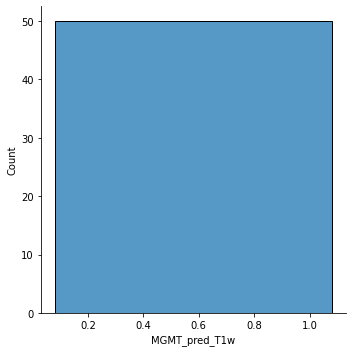

In [15]:
# T1w
# mri_types = ['T1w','FLAIR','T1wCE','T2w']

mri_types = ['T1w','T1w','T1w']
modelfiles = ["T1w-e1-loss0.706-auc0.500.pth","T1w-e4-loss0.693-auc0.498.pth","T1w-e2-loss0.694-auc0.500.pth"]
df_test["MGMT_pred_T1w"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_test, mtype, "test")
    df_test["MGMT_pred_T1w"] = pred["MGMT_value"]
    auc = roc_auc_score(df_test["MGMT_value"], df_test["MGMT_pred_T1w"])
    print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_test["MGMT_pred_T1w"])
df_test.head()

Predict: T1wCE-e1-loss0.692-auc0.515.pth T1wCE (50, 5)
Validation ensemble AUC: 0.4750
Predict: T1wCE-e2-loss0.691-auc0.500.pth T1wCE (50, 5)
Validation ensemble AUC: 0.4783
Predict: T1wCE-e3-loss0.691-auc0.408.pth T1wCE (50, 5)
Validation ensemble AUC: 0.4686
Predict: T1wCE-e5-loss0.688-auc0.602.pth T1wCE (50, 5)
Validation ensemble AUC: 0.4364
Predict: T1wCE-e4-loss0.690-auc0.587.pth T1wCE (50, 5)
Validation ensemble AUC: 0.5089


,MGMT_value,MGMT_pred_flair,MRI_Type,MGMT_pred_T1w,MGMT_pred_T1wCE
BraTS21ID,,,,,
499,1,0.515328,T1wCE,0.580202,0.541939
775,1,0.544773,T1wCE,0.580202,0.542009
401,0,0.544335,T1wCE,0.580202,0.541978
593,1,0.542593,T1wCE,0.580202,0.542011
421,0,0.531726,T1wCE,0.580202,0.541924


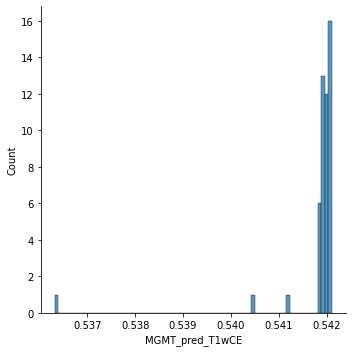

In [16]:
# T1wCE
# mri_types = ['T1w','FLAIR','T1wCE','T2w']

mri_types = ['T1wCE','T1wCE','T1wCE','T1wCE','T1wCE']
modelfiles = ["T1wCE-e1-loss0.692-auc0.515.pth","T1wCE-e2-loss0.691-auc0.500.pth","T1wCE-e3-loss0.691-auc0.408.pth",
              "T1wCE-e5-loss0.688-auc0.602.pth", "T1wCE-e4-loss0.690-auc0.587.pth"]
df_test["MGMT_pred_T1wCE"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_test, mtype, "test")
    df_test["MGMT_pred_T1wCE"] = pred["MGMT_value"]
    auc = roc_auc_score(df_test["MGMT_value"], df_test["MGMT_pred_T1wCE"])
    print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_test["MGMT_pred_T1wCE"])
df_test.head()

Predict: T2w-e1-loss0.702-auc0.500.pth T2w (50, 6)
Validation ensemble AUC: 0.5000
Predict: T2w-e2-loss0.692-auc0.500.pth T2w (50, 6)
Validation ensemble AUC: 0.5000
Predict: T2w-e4-loss0.691-auc0.433.pth T2w (50, 6)
Validation ensemble AUC: 0.5072
Predict: T2w-e10-loss0.688-auc0.586.pth T2w (50, 6)
Validation ensemble AUC: 0.5733


,MGMT_value,MGMT_pred_flair,MRI_Type,MGMT_pred_T1w,MGMT_pred_T1wCE,MGMT_pred_T2w
BraTS21ID,,,,,,
499,1,0.515328,T2w,0.580202,0.541939,0.548282
775,1,0.544773,T2w,0.580202,0.542009,0.532590
401,0,0.544335,T2w,0.580202,0.541978,0.514167
593,1,0.542593,T2w,0.580202,0.542011,0.518971
421,0,0.531726,T2w,0.580202,0.541924,0.515910


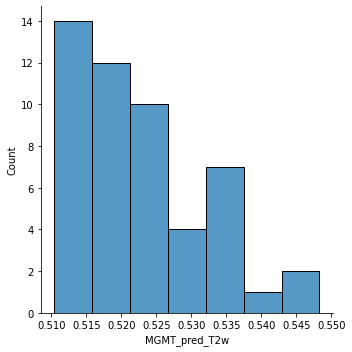

In [17]:
# T2w
# mri_types = ['T1w','FLAIR','T1wCE','T2w']

mri_types = ['T2w','T2w','T2w','T2w']
modelfiles = ["T2w-e1-loss0.702-auc0.500.pth","T2w-e2-loss0.692-auc0.500.pth",
             "T2w-e4-loss0.691-auc0.433.pth","T2w-e10-loss0.688-auc0.586.pth"]
df_test["MGMT_pred_T2w"] = 0
for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_test, mtype, "test")
    df_test["MGMT_pred_T2w"] = pred["MGMT_value"]
    auc = roc_auc_score(df_test["MGMT_value"], df_test["MGMT_pred_T2w"])
    print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_test["MGMT_pred_T2w"])
df_test.head()

Predict: T1w-e1-loss0.706-auc0.500.pth T1w (50, 7)
Predict: FLAIR-e5-loss0.685-auc0.576.pth FLAIR (50, 7)
Predict: T1wCE-e4-loss0.690-auc0.587.pth T1wCE (50, 7)
Predict: T2w-e10-loss0.688-auc0.586.pth T2w (50, 7)
Validation ensemble AUC: 0.6055


,MGMT_value,MGMT_pred_flair,MRI_Type,MGMT_pred_T1w,MGMT_pred_T1wCE,MGMT_pred_T2w,MGMT_pred_av1
BraTS21ID,,,,,,,
499,1,0.515328,T2w,0.580202,0.541939,0.548282,0.513448
775,1,0.544773,T2w,0.580202,0.542009,0.532590,0.516904
401,0,0.544335,T2w,0.580202,0.541978,0.514167,0.512181
593,1,0.542593,T2w,0.580202,0.542011,0.518971,0.512954
421,0,0.531726,T2w,0.580202,0.541924,0.515910,0.509450


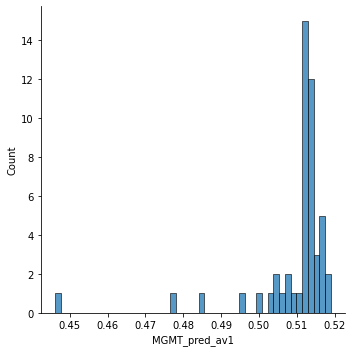

In [18]:
# average1
# df_test = df_test.set_index("BraTS21ID")
mri_types = ['T1w','FLAIR','T1wCE','T2w']
modelfiles = ["T1w-e1-loss0.706-auc0.500.pth","FLAIR-e5-loss0.685-auc0.576.pth","T1wCE-e4-loss0.690-auc0.587.pth",
             "T2w-e10-loss0.688-auc0.586.pth"]
df_test["MGMT_pred_av1"] = 0

for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_test, mtype, "test")
    df_test["MGMT_pred_av1"] += pred["MGMT_value"]
df_test["MGMT_pred_av1"] /= len(modelfiles)
auc = roc_auc_score(df_test["MGMT_value"], df_test["MGMT_pred_av1"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_test["MGMT_pred_av1"])
df_test.head()

Predict: FLAIR-e5-loss0.685-auc0.576.pth FLAIR (50, 8)
Predict: T1wCE-e4-loss0.690-auc0.587.pth T1wCE (50, 8)
Predict: T2w-e10-loss0.688-auc0.586.pth T2w (50, 8)
Validation ensemble AUC: 0.6055


,MGMT_value,MGMT_pred_flair,MRI_Type,MGMT_pred_T1w,MGMT_pred_T1wCE,MGMT_pred_T2w,MGMT_pred_av1,MGMT_pred_av2
BraTS21ID,,,,,,,,
499,1,0.515328,T2w,0.580202,0.541939,0.548282,0.513448,0.535183
775,1,0.544773,T2w,0.580202,0.542009,0.532590,0.516904,0.539791
401,0,0.544335,T2w,0.580202,0.541978,0.514167,0.512181,0.533493
593,1,0.542593,T2w,0.580202,0.542011,0.518971,0.512954,0.534525
421,0,0.531726,T2w,0.580202,0.541924,0.515910,0.509450,0.529853


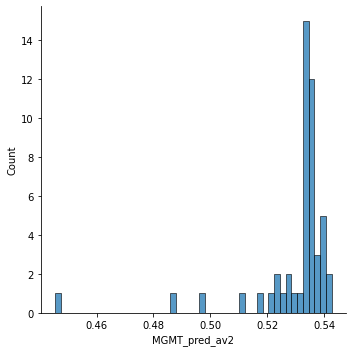

In [19]:
# average2
# df_test = df_test.set_index("BraTS21ID")
mri_types = ['FLAIR','T1wCE','T2w']
modelfiles = ["FLAIR-e5-loss0.685-auc0.576.pth","T1wCE-e4-loss0.690-auc0.587.pth",
             "T2w-e10-loss0.688-auc0.586.pth"]
df_test["MGMT_pred_av2"] = 0

for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_test, mtype, "test")
    df_test["MGMT_pred_av2"] += pred["MGMT_value"]
df_test["MGMT_pred_av2"] /= len(modelfiles)
auc = roc_auc_score(df_test["MGMT_value"], df_test["MGMT_pred_av2"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_test["MGMT_pred_av2"])
df_test.head()

Predict: FLAIR-e5-loss0.685-auc0.576.pth FLAIR (50, 9)
Predict: T2w-e10-loss0.688-auc0.586.pth T2w (50, 9)
Validation ensemble AUC: 0.6055


,MGMT_value,MGMT_pred_flair,MRI_Type,MGMT_pred_T1w,MGMT_pred_T1wCE,MGMT_pred_T2w,MGMT_pred_av1,MGMT_pred_av2,MGMT_pred_av3
BraTS21ID,,,,,,,,,
499,1,0.515328,T2w,0.580202,0.541939,0.548282,0.513448,0.535183,0.531805
775,1,0.544773,T2w,0.580202,0.542009,0.532590,0.516904,0.539791,0.538682
401,0,0.544335,T2w,0.580202,0.541978,0.514167,0.512181,0.533493,0.529251
593,1,0.542593,T2w,0.580202,0.542011,0.518971,0.512954,0.534525,0.530782
421,0,0.531726,T2w,0.580202,0.541924,0.515910,0.509450,0.529853,0.523818


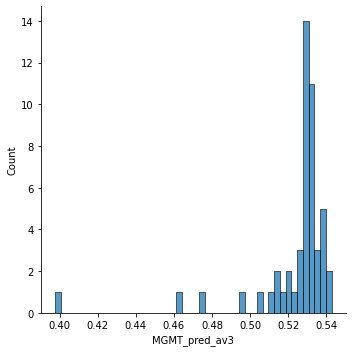

In [20]:
# average3
# df_test = df_test.set_index("BraTS21ID")
mri_types = ['FLAIR','T2w']
modelfiles = ["FLAIR-e5-loss0.685-auc0.576.pth",
             "T2w-e10-loss0.688-auc0.586.pth"]
df_test["MGMT_pred_av3"] = 0

for m, mtype in zip(modelfiles,  mri_types):
    pred = predict(m, df_test, mtype, "test")
    df_test["MGMT_pred_av3"] += pred["MGMT_value"]
df_test["MGMT_pred_av3"] /= len(modelfiles)
auc = roc_auc_score(df_test["MGMT_value"], df_test["MGMT_pred_av3"])
print(f"Validation ensemble AUC: {auc:.4f}")
sns.displot(df_test["MGMT_pred_av3"])
df_test.head()

No handles with labels found to put in legend.


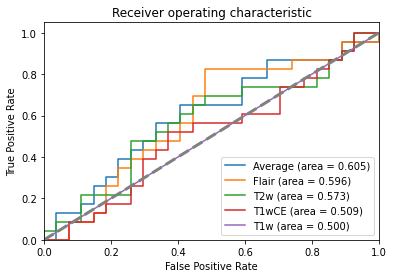

In [32]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

plt.figure(0).clf()
# plt.figure(figsize=(10,10))

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

pred = np.array(df_test["MGMT_pred_av1"])
label = np.array(df_test["MGMT_value"])
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label='Average (area = %0.3f)' % auc)

pred = np.array(df_test["MGMT_pred_flair"])
label = np.array(df_test["MGMT_value"])
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label='Flair (area = %0.3f)' % auc)

pred = np.array(df_test["MGMT_pred_T2w"])
label = np.array(df_test["MGMT_value"])
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label='T2w (area = %0.3f)' % auc)

pred = np.array(df_test["MGMT_pred_T1wCE"])
label = np.array(df_test["MGMT_value"])
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label='T1wCE (area = %0.3f)' % auc)

pred = np.array(df_test["MGMT_pred_T1w"])
label = np.array(df_test["MGMT_value"])
fpr, tpr, thresh = metrics.roc_curve(label, pred)
auc = metrics.roc_auc_score(label, pred)
plt.plot(fpr,tpr,label='T1w (area = %0.3f)' % auc)


plt.plot([0, 1], [0, 1], color='grey',lw = 3,linestyle='--')

# pred = np.array(df_test["MGMT_pred_av2"])
# label = np.array(df_test["MGMT_value"])
# fpr, tpr, thresh = metrics.roc_curve(label, pred)
# auc = metrics.roc_auc_score(label, pred)
# plt.plot(fpr,tpr,label="Average 2, auc="+str(auc))


plt.legend(loc=0)